**Attribution:** These notebooks were originally developed by Mary Wotters and have possibly been modified by Moses Charikar and Nima Anari. Any blames should be directed to Nima and Moses.


# Minimum Spanning Trees

In [4]:
from graphStuff import *
import heapdict as heapdict # you will need to install heapdict to use this
import time
import matplotlib
import numpy as np
from random import random
from random import choice
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

First, let's implement the "slowPrim" greedy algorithm that we saw in class

In [2]:
# G is a connected CS161Graph, s is a vertex to start at.
def slowPrim(G,s):
    # first, find the lightest edge leaving s
    bestWt = np.inf
    bestu = None
    for u,wt in s.getOutNeighborsWithWeights():
        if wt < bestWt:
            bestWt = wt
            bestu = u
    MST = [ (s,bestu) ]
    verticesVisited = [s,bestu]
    while len(verticesVisited) < len(G.vertices): # danger! this will loop forever if the graph isn't connected...
        # find the lightest edge (x,v) so that x has been visited and v hasn't.
        bestWt = np.inf
        bestv = None
        bestx = None
        for x in verticesVisited:
            for v,wt in x.getOutNeighborsWithWeights():
                if v in verticesVisited:
                    continue
                if wt < bestWt:
                    bestWt = wt
                    bestv = v
                    bestx = x
        MST.append((bestx,bestv))
        verticesVisited.append(bestv)
    return MST

(Some quick sanity checks)

In [3]:
# As a sanity check, let's make a random graph
def makeRandomGraph(n,p):
    G = CS161Graph()
    for i in range(n):
        G.addVertex(CS161Vertex(i))
    for i in range(n):
        for j in range(i+1,n):
            if random() < p:
                G.addBiEdge(G.vertices[i], G.vertices[j], wt=random())
    return G

In [4]:
# this is a complete graph with random edge weights 
G = makeRandomGraph(4,1)
print(G)

CS161Graph with:
	 Vertices:
	0,1,2,3,
	 Edges:
	(0,1; wt:0.8402066952153024) (0,2; wt:0.1415756919797576) (0,3; wt:0.17780500702331348) (1,0; wt:0.8402066952153024) (1,2; wt:0.7698677343077575) (1,3; wt:0.704068213028623) (2,0; wt:0.1415756919797576) (2,1; wt:0.7698677343077575) (2,3; wt:0.22455156738428528) (3,0; wt:0.17780500702331348) (3,1; wt:0.704068213028623) (3,2; wt:0.22455156738428528) 



In [5]:
# do we get a MST?  (Seems ok)
T = slowPrim(G,G.vertices[0])
for x,y in T:
    print(x,y)

0 2
0 3
3 1


### Now let's implement prim's algorithm for real:

In [6]:
# Not gonna lie, totally copied-and-pasted the Dijkstra code from Lecture 11 as a starting point -- they are quite similar!
def prim(G,w):
    for v in G.vertices:
        v.estD = np.inf
    w.estD = 0
    MST = []
    unvisitedVertices = heapdict.heapdict()
    for v in G.vertices:
        unvisitedVertices[v] = v.estD
    while len(unvisitedVertices) > 0:
        # find the u with the minimum estD, using the heap
        u, dist = unvisitedVertices.popitem() 
        if u.estD == np.inf:
            # then there is nothing more that I can reach; this shouldn't happen if the graph is connected
            return "Graph disconnected :("
        # add u to the MST
        if u.parent != None:  # don't do it for the first vertex
            MST.append((u.parent,u))
        # update u's neighbors
        for v,wt in u.getOutNeighborsWithWeights():
            if v in unvisitedVertices:
                if wt < v.estD:
                    v.estD = wt
                    unvisitedVertices[v] =  wt #update the key in the heapdict
                    v.parent = u # v points to u now
    return MST

In [7]:
# make sure it does the same thing as slowPrim
G = makeRandomGraph(14,1)
Tprim = prim(G,G.vertices[0])
Tslow = slowPrim(G,G.vertices[0])

for i in range(len(Tprim)):
    x,y = Tprim[i]
    a,b = Tslow[i]
    print(x,y ,"\t vs \t", a, b)


def areEqual(A,B):
    if len(A) != len(B):
        return False
    for a in A:
        if a not in B:
            return False
    return True

if areEqual(Tprim,Tslow):
    print("It worked!")

0 1 	 vs 	 0 1
1 11 	 vs 	 1 11
11 10 	 vs 	 11 10
10 4 	 vs 	 10 4
4 6 	 vs 	 4 6
6 13 	 vs 	 6 13
10 8 	 vs 	 10 8
8 12 	 vs 	 8 12
12 7 	 vs 	 12 7
8 9 	 vs 	 8 9
6 2 	 vs 	 6 2
2 5 	 vs 	 2 5
5 3 	 vs 	 5 3
It worked!


In [8]:
# generate a bunch of random graphs and run an alg to compute shortest paths (implicitly)  
def runTrials(myFn, nVals, pFn, numTrials=25):
    nValues = []
    tValues = []
    for n in nVals:
        # run myFn several times and average to get a decent idea.
        runtime = 0
        for t in range(numTrials):
            G = makeRandomGraph(n, pFn(n))  #Random graph on n vertices with about pn^2 edges
            start = time.time()
            myFn( G, G.vertices[0]) 
            end = time.time()
            runtime += (end - start) * 1000 # measure in milliseconds
        runtime = runtime/numTrials
        nValues.append(n)
        tValues.append(runtime)
    return nValues, tValues

In [9]:
def smallFrac(n):
    return float(10/n)
nValues = [10,50,100,150,200]
nSlowPrim, tSlowPrim = runTrials(slowPrim, nValues,smallFrac)
nPrim, tPrim = runTrials(prim, nValues,smallFrac)

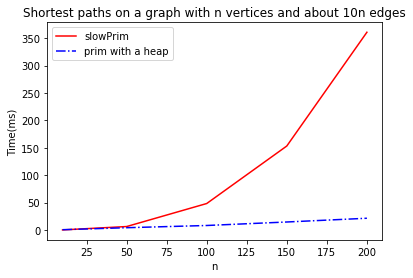

In [10]:
plt.plot(nSlowPrim, tSlowPrim, color="red", label="slowPrim")
plt.plot(nPrim, tPrim, "-.", color="blue", label="prim with a heap")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Shortest paths on a graph with n vertices and about 10n edges")
plt.show()